## Import Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import re
import glob
import random
import yaml

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

import IPython.display as display
from PIL import Image
import cv2

from ultralytics import YOLO

## Configuring Parameters

In [3]:
debug = False
fraction = 0.05 if debug else 1.0
seed = 88

# classes
classes = ['Person']
num_train_classes = len(classes)

# training
epochs = 10
batch_size = 16

# model
# model = 'yolov8n.pt'
base_model = 'yolov8x'
# weights = f'{model}.pt'
weights = 'yolov8n.pt'
exp_name = f'person_det_{epochs}_epochs' 

# optimiser
optimiser = 'Adam' # was auto before
lr = 1e-3
lr_factor = 0.01
weight_decay = 5e-4
dropout = 0.0
patience = 20
profile = False
label_smoothing = 0.0

## Dataset

In [4]:
dataset_dir = 'C:/Users/arian/Documents/University/Masters Year/Dissertation/Model Training/Person detection/Images'
output = './'

dict_file = {
    'train': os.path.join(dataset_dir, 'train'),
    'val': os.path.join(dataset_dir, 'valid'),
    'test': os.path.join(dataset_dir, 'test'),
    'nc': num_train_classes,
    'names': classes
}

with open(os.path.join(output, 'data.yaml'), 'w+') as file:
    yaml.dump(dict_file, file) # produces info as a yaml file

# read yaml file
def read_yaml(path = dataset_dir):
    with open(path, 'r') as file:
        try:
            data = yaml.safe_load(file)
            return data
        except yaml.YAMLError as exc:
            print('Error reading YAML',exc)
            return None

# print yaml
def print_yaml(data):
    formatted_yaml = yaml.dump(data, default_style=False)
    print(formatted_yaml)

In [5]:
path = os.path.join(output, 'data.yaml')
yaml_data = read_yaml(path)

if yaml_data:
    print_yaml(yaml_data)

names:
- Person
nc: 1
test: C:/Users/arian/Documents/University/Masters Year/Dissertation/Model Training/Person
  detection/Images\test
train: C:/Users/arian/Documents/University/Masters Year/Dissertation/Model Training/Person
  detection/Images\train
val: C:/Users/arian/Documents/University/Masters Year/Dissertation/Model Training/Person
  detection/Images\valid



## Test Dataset

In [6]:
## displays one image
def display_image(image, print_info = True, hide_axis = False):
    if isinstance(image, str):  # Check if it's a file path
        img = Image.open(image)
        plt.imshow(img)
    elif isinstance(image, np.ndarray):  # Check if it's a NumPy array
        image = image[..., ::-1]  # BGR to RGB
        img = Image.fromarray(image)
        plt.imshow(img)
    else:
        raise ValueError("Unsupported image format")

    if print_info:
        print('Type: ', type(img), '\n')
        print('Shape: ', np.array(img).shape, '\n')

    if hide_axis:
        plt.axis('off')

    plt.show()

## displays random images from dataset
def plot_img_rand(path, num_images=5, seed=seed):
    random.seed(seed)
    
    img_files = [f for f in os.listdir(path) if f.endswith('.jpg')]
    
    select_files = random.sample(img_files, num_images) # randomly select images
    
    # Create a subplot grid
    cols = 5
    rows = (num_images + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(12, 8))
    
    for i, file_name in enumerate(select_files):
        # Open and display the image using PIL
        img = Image.open(os.path.join(path, file_name))
        
        if rows == 1:
            ax = axes[i % cols]
        else:
            ax = axes[i // cols, i % cols]
        
        ax.imshow(img)
        ax.axis('off')
        # ax.set_title(file_name)
    

Type:  <class 'PIL.JpegImagePlugin.JpegImageFile'> 

Shape:  (640, 640, 3) 



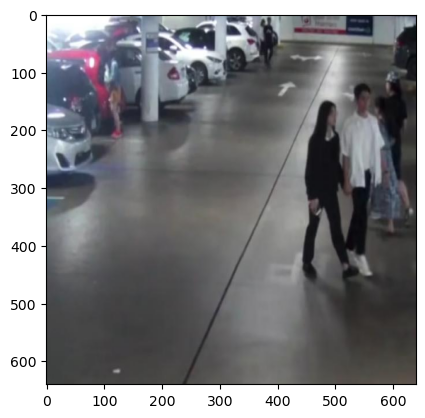

In [7]:
img_path = 'C:/Users/arian/Documents/University/Masters Year/Dissertation/Model Training/Person detection/Images/train/images/4_png.rf.0b92908b131ab813b0bfe0f331af5c98.jpg'

display_image(img_path, print_info = True, hide_axis = False)

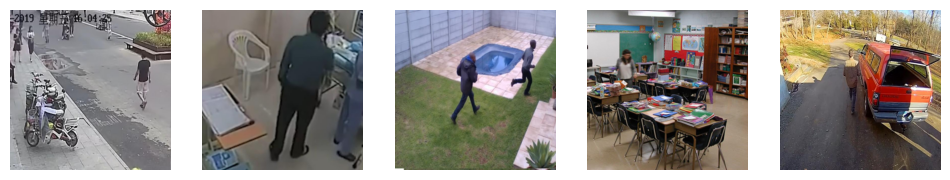

In [8]:
folder_path = 'C:/Users/arian/Documents/University/Masters Year/Dissertation/Model Training/Person detection/Images/train/images/'

# display random images
plot_img_rand(folder_path, num_images=5, seed=seed)

## Data Preprocessing

In [9]:
class_idx = {str(i): classes[i] for i in range(num_train_classes)}

class_stat = {}
data_len = {}
class_info = []

for mode in ['train', 'valid', 'test']:
    class_count = {classes[i]: 0 for i in range(num_train_classes)}

    path = os.path.join(dataset_dir, mode, 'labels')
    
    for file in os.listdir(path):
        with open(os.path.join(path, file)) as f:
            lines = f.readlines()

            for cls in set([line[0] for line in lines]):
                class_count[class_idx[cls]] += 1
                
    data_len[mode] = len(os.listdir(path))
    class_stat[mode] = class_count
    
    class_info.append({'Mode': mode, **class_count, 'Data_Volume': data_len[mode]})
    
dataset_stats_df = pd.DataFrame(class_info)
dataset_stats_df



,Mode,Person,Data_Volume
0,train,385,385
1,valid,110,110
2,test,55,55


## Model Training

In [10]:
## Load pretrained model
model = YOLO(weights) # yolov8n.pt

# train
model.train(
    data = os.path.join(output, 'data.yaml'),
    task = 'detect',
    
    epochs = epochs,
    batch = batch_size,
    optimizer = optimiser,
    lr0 = lr,
    lrf = lr_factor,
    weight_decay = weight_decay,
    dropout = dropout,
    fraction = fraction,
    patience = patience,
    profile = profile,
    label_smoothing = label_smoothing,
    
    name = f'{base_model}_{exp_name}',
    seed = seed,
    
    val = True,
    amp = True,
    exist_ok = True,
    resume = False,
    # device = 0,
    verbose = False,
)

New https://pypi.org/project/ultralytics/8.3.104 available  Update with 'pip install -U ultralytics'
WARNING  'label_smoothing' is deprecated and will be removed in in the future.
Ultralytics 8.3.82  Python-3.11.11 torch-2.6.0+cpu CPU (13th Gen Intel Core(TM) i7-13700H)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=./data.yaml, epochs=10, time=None, patience=20, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov8x_person_det_10_epochs, exist_ok=True, pretrained=True, optimizer=Adam, verbose=False, seed=88, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=F

train: Scanning C:\Users\arian\Documents\University\Masters Year\Dissertation\Model Training\Person detection\Images\train\labels.cache... 385 images, 0 backgrounds, 0 corrupt: 100%|██████████| 385/385 [00:00<?, ?it/s]
val: Scanning C:\Users\arian\Documents\University\Masters Year\Dissertation\Model Training\Person detection\Images\valid\labels.cache... 110 images, 0 backgrounds, 0 corrupt: 100%|██████████| 110/110 [00:00<?, ?it/s]

Plotting labels to runs\detect\yolov8x_person_det_10_epochs\labels.jpg... 


optimizer: Adam(lr=0.001, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\detect\yolov8x_person_det_10_epochs
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10         0G      1.378      2.038      1.473          4        640: 100%|██████████| 25/25 [02:26<00:00,  5.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:19<00:00,  4.92s/it]

                   all        110        190     0.0116      0.521      0.185     0.0873



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10         0G      1.361      1.407      1.408          2        640: 100%|██████████| 25/25 [03:03<00:00,  7.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:21<00:00,  5.27s/it]

                   all        110        190      0.851      0.395      0.558      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10         0G      1.321      1.309      1.365          2        640: 100%|██████████| 25/25 [02:35<00:00,  6.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:22<00:00,  5.58s/it]

                   all        110        190      0.746      0.379      0.519      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10         0G      1.301      1.222      1.364          1        640: 100%|██████████| 25/25 [02:24<00:00,  5.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:19<00:00,  4.79s/it]

                   all        110        190      0.774      0.579      0.688      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10         0G      1.252      1.245      1.336          2        640: 100%|██████████| 25/25 [02:57<00:00,  7.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:23<00:00,  5.86s/it]

                   all        110        190       0.85      0.742      0.839      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10         0G      1.199      1.112      1.282          1        640: 100%|██████████| 25/25 [03:21<00:00,  8.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:19<00:00,  4.77s/it]

                   all        110        190      0.833      0.763      0.845      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10         0G      1.163      1.035      1.281          1        640: 100%|██████████| 25/25 [01:23<00:00,  3.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:08<00:00,  2.15s/it]

                   all        110        190      0.856      0.716      0.833      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10         0G      1.118      1.016      1.259          2        640: 100%|██████████| 25/25 [02:38<00:00,  6.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:22<00:00,  5.62s/it]

                   all        110        190      0.855      0.789      0.877      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10         0G       1.03     0.9357      1.189          1        640: 100%|██████████| 25/25 [03:39<00:00,  8.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:24<00:00,  6.21s/it]

                   all        110        190      0.838      0.791      0.889      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10         0G      1.085     0.9661      1.213          1        640: 100%|██████████| 25/25 [03:14<00:00,  7.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:08<00:00,  2.06s/it]

                   all        110        190      0.876      0.821      0.906      0.648



10 epochs completed in 0.518 hours.
Optimizer stripped from runs\detect\yolov8x_person_det_10_epochs\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\yolov8x_person_det_10_epochs\weights\best.pt, 6.2MB

Validating runs\detect\yolov8x_person_det_10_epochs\weights\best.pt...
Ultralytics 8.3.82  Python-3.11.11 torch-2.6.0+cpu CPU (13th Gen Intel Core(TM) i7-13700H)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  1.76s/it]


                   all        110        190      0.876      0.821      0.905      0.649
Speed: 1.2ms preprocess, 52.3ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs\detect\yolov8x_person_det_10_epochs


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001340A223250>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0480

## Export Model

In [11]:
model.export(
    format = 'openvino',
    half = False,
    int8 = False,
    simplify = False,
    nms = False,
)

Ultralytics 8.3.82  Python-3.11.11 torch-2.6.0+cpu CPU (13th Gen Intel Core(TM) i7-13700H)


Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs

PyTorch: starting from 'runs\detect\yolov8x_person_det_10_epochs\weights\best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (6.0 MB)

OpenVINO: starting export with openvino 2024.6.0-17404-4c0f47d2335-releases/2024/6...
OpenVINO: export success  7.9s, saved as 'runs\detect\yolov8x_person_det_10_epochs\weights\best_openvino_model\' (11.8 MB)

Export complete (9.2s)
Results saved to C:\Users\arian\Documents\University\Masters Year\Dissertation\Model Training\Person detection\runs\detect\yolov8x_person_det_10_epochs\weights
Predict:         yolo predict task=detect model=runs\detect\yolov8x_person_det_10_epochs\weights\best_openvino_model imgsz=640  
Validate:        yolo val task=detect model=runs\detect\yolov8x_person_det_10_epochs\weights\best_openvino_model imgsz=640 data=./data.yaml  
Visualize:       https://netron.app


'runs\\detect\\yolov8x_person_det_10_epochs\\weights\\best_openvino_model'

## Results

./runs/detect/yolov8x_person_det_10_epochs\F1_curve.png


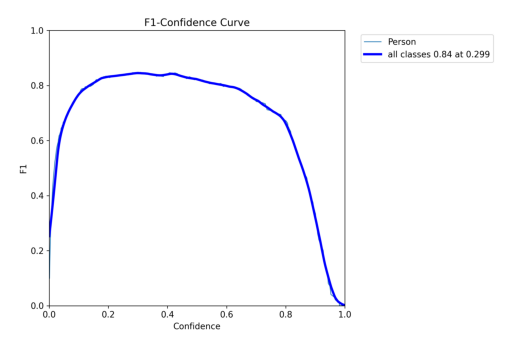



./runs/detect/yolov8x_person_det_10_epochs\PR_curve.png


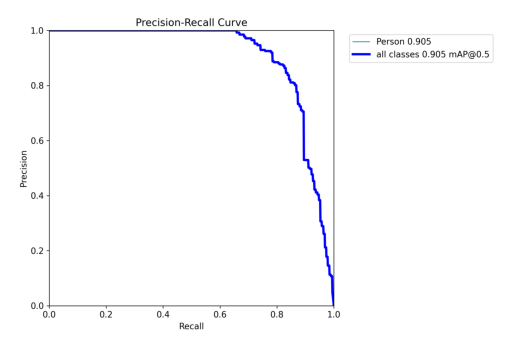



./runs/detect/yolov8x_person_det_10_epochs\P_curve.png


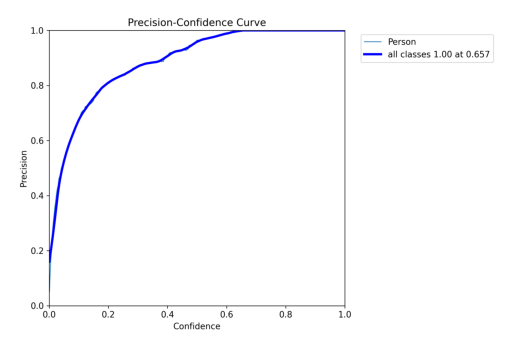



./runs/detect/yolov8x_person_det_10_epochs\R_curve.png


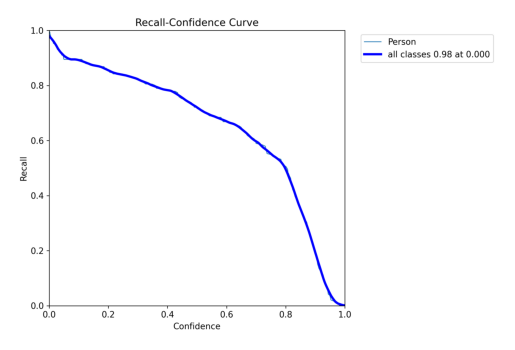



./runs/detect/yolov8x_person_det_10_epochs\confusion_matrix.png


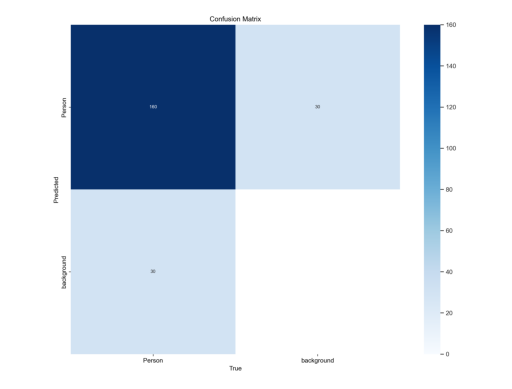



./runs/detect/yolov8x_person_det_10_epochs\confusion_matrix_normalized.png


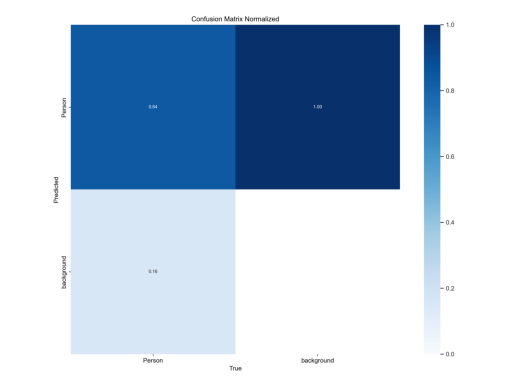



./runs/detect/yolov8x_person_det_10_epochs\labels.jpg


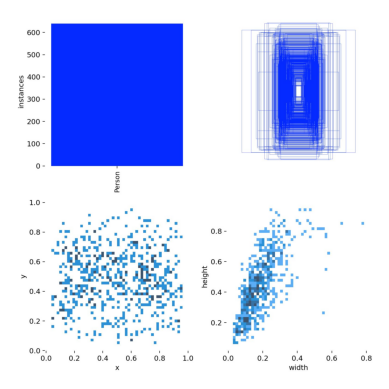



./runs/detect/yolov8x_person_det_10_epochs\labels_correlogram.jpg


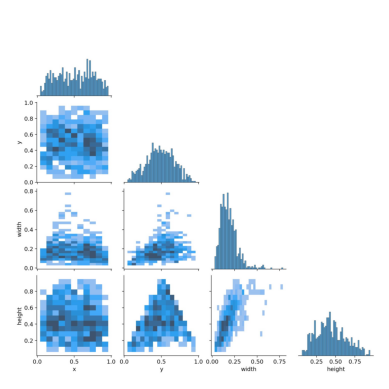



./runs/detect/yolov8x_person_det_10_epochs\results.png


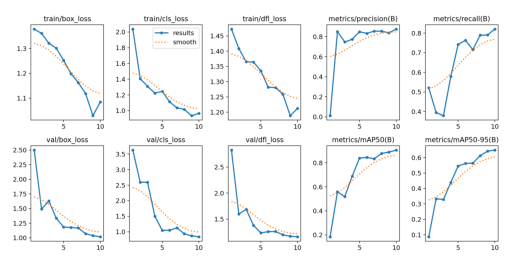



**************************************************

Best Training loss:  1.02962 , on epoch:  9 

**************************************************

Best Validation loss:  1.01854 , on epoch:  10 

**************************************************


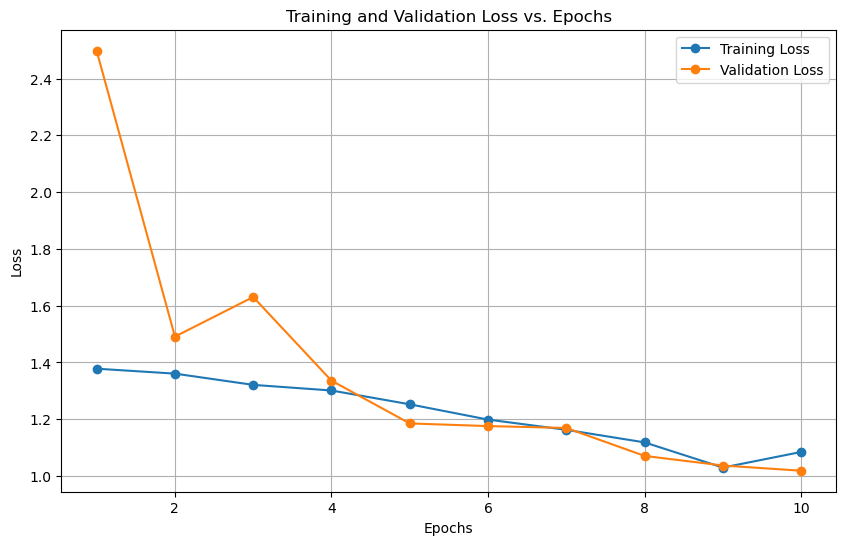

In [12]:
results_path = [
    i for i in
    glob.glob(f'{output}runs/detect/{base_model}_{exp_name}/*.png') +
    glob.glob(f'{output}runs/detect/{base_model}_{exp_name}/*.jpg')
    if 'batch' not in i
]

for file in sorted(results_path):
    print(file)
    display_image(file, print_info = False, hide_axis = True)
    print('\n')
    
## Print best training and validation loss
df = pd.read_csv(f'{output}runs/detect/{base_model}_{exp_name}/results.csv')
df = df.rename(columns=lambda x: x.replace(" ", ""))
df.to_csv(f'{output}training_log_df.csv', index=False)
    
print('*'*50)
print('\nBest Training loss: ', df['train/box_loss'].min(), ', on epoch: ', df['train/box_loss'].argmin() + 1, '\n')
print('*'*50)
print('\nBest Validation loss: ', df['val/box_loss'].min(), ', on epoch: ', df['val/box_loss'].argmin() + 1, '\n')
print('*'*50)

## Training and Validation Loss vs. Epoch
plt.figure(figsize=(10, 6))
plt.plot(df['epoch'], df['train/box_loss'], label='Training Loss', marker='o', linestyle='-')
plt.plot(df['epoch'], df['val/box_loss'], label='Validation Loss', marker='o', linestyle='-')

plt.title('Training and Validation Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.grid(True)
plt.show()

## Validation

./runs/detect/yolov8x_person_det_10_epochs\val_batch2_pred.jpg
./runs/detect/yolov8x_person_det_10_epochs\val_batch2_pred.jpg


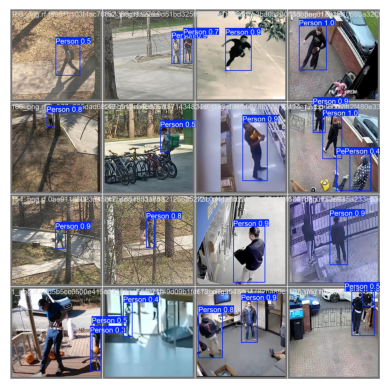

In [13]:
validation_results_paths = [
    i for i in
    glob.glob(f'{output}runs/detect/{base_model}_{exp_name}/*.png') +
    glob.glob(f'{output}runs/detect/{base_model}_{exp_name}/*.jpg')
    if 'val_batch' in i
]

if len(validation_results_paths) >= 1:
    print(validation_results_paths[-1])
### check predictions or labels from a random validation batch
if len(validation_results_paths) >= 1:
    val_img_path = random.choice(validation_results_paths)
    print(val_img_path)
    
    display_image(val_img_path, print_info = False, hide_axis = True)